# 1.Training and validation - Regression Tree Boston Dataset GBM

In [1]:
# Librerias base
library(caret) # Libreria de Machine learning
library(Matrix) # Libreria para componer eleentos matriciales
library(rpart) # Libreria para generar el decision tree
library(e1071)

# Librerias para visualizar el decision tree
library(rattle)
library(rpart.plot)
library(RColorBrewer)
library(dplyr)
library(gbm)

Loading required package: lattice

Loading required package: ggplot2

Rattle: A free graphical interface for data science with R.
Versión 5.3.0 Copyright (c) 2006-2018 Togaware Pty Ltd.
Escriba 'rattle()' para agitar, sacudir y  rotar sus datos.


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loaded gbm 2.1.5



Cargamos el raw dataset

In [2]:
raw_data = read.csv('datos_ciudad.csv', sep = ',')
head(raw_data)

,crime_index,urban_ratio,industry_ratio,c_river_variable,nox_concentration,rooms_per_dwelling,dwelling_age,dwelling_dist,highway_index,tax_ratio,teacher_ratio,racial_index,lower_status,median_value,class
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,0
2,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,0
3,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,0
4,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,0
5,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,0
6,0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7,0


In [3]:
# En este caso retiramos la variable de median_value pues buscamos clasificar 
class = c(15)
raw_data_no_value = raw_data[,-class]
raw_data_no_value = raw_data_no_value[complete.cases(raw_data_no_value), ]
head(raw_data_no_value)

,crime_index,urban_ratio,industry_ratio,c_river_variable,nox_concentration,rooms_per_dwelling,dwelling_age,dwelling_dist,highway_index,tax_ratio,teacher_ratio,racial_index,lower_status,median_value
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
6,0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


In [4]:
# Generamos 2 datasets para nuestro modelo
set.seed(123)

# Percentages
fractionTraining   <- 0.80
fractionValidation <- 0.20

# Compute sample sizes.
sampleSizeTraining   <- floor(fractionTraining   * nrow(raw_data_no_value))
sampleSizeValidation <- floor(fractionValidation * nrow(raw_data_no_value))

# Create the randomly-sampled indices for the dataframe. Use setdiff() to
# avoid overlapping subsets of indices.
indicesTraining    <- sort(sample(seq_len(nrow(raw_data_no_value)), size=sampleSizeTraining))
indicesNotTraining <- setdiff(seq_len(nrow(raw_data_no_value)), indicesTraining)
indicesValidation  <- sort(sample(indicesNotTraining, size=sampleSizeValidation))

# Finally, output the three dataframes for training, validation and test.
dfTraining   <- raw_data_no_value[indicesTraining, ]
dfValidation <- raw_data_no_value[indicesValidation, ]

In [5]:
head(dfValidation)
head(dfTraining)

,crime_index,urban_ratio,industry_ratio,c_river_variable,nox_concentration,rooms_per_dwelling,dwelling_age,dwelling_dist,highway_index,tax_ratio,teacher_ratio,racial_index,lower_status,median_value
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
15,0.63796,0,8.14,0,0.538,6.096,84.5,4.4619,4,307,21.0,380.02,10.26,18.2
17,1.05393,0,8.14,0,0.538,5.935,29.3,4.4986,4,307,21.0,386.85,6.58,23.1
19,0.80271,0,8.14,0,0.538,5.456,36.6,3.7965,4,307,21.0,288.99,11.69,20.2
28,0.95577,0,8.14,0,0.538,6.047,88.8,4.4534,4,307,21.0,306.38,17.28,14.8
37,0.09744,0,5.96,0,0.499,5.841,61.4,3.3779,5,279,19.2,377.56,11.41,20.0


,crime_index,urban_ratio,industry_ratio,c_river_variable,nox_concentration,rooms_per_dwelling,dwelling_age,dwelling_dist,highway_index,tax_ratio,teacher_ratio,racial_index,lower_status,median_value
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
6,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


## Modelo

In [6]:
fitControl <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 10,
                           ## repeated fifty times
                           repeats = 50)

set.seed(825)

gbmFit <- train(median_value ~ .
                 , data = dfTraining, 
                 , method = "gbm"
                 , trControl = fitControl
                 , verbose = FALSE)
gbmFit

Stochastic Gradient Boosting 

404 samples
 13 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 50 times) 
Summary of sample sizes: 363, 364, 363, 364, 364, 364, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  RMSE      Rsquared   MAE     
  1                   50      4.105924  0.8008901  2.861565
  1                  100      3.831614  0.8219639  2.643447
  1                  150      3.738689  0.8305137  2.581380
  2                   50      3.703641  0.8332756  2.563088
  2                  100      3.467819  0.8531016  2.407484
  2                  150      3.371107  0.8616142  2.357406
  3                   50      3.512779  0.8496621  2.400715
  3                  100      3.311471  0.8666512  2.281852
  3                  150      3.229799  0.8735118  2.240257

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held constant at a value of 10
RMSE was used to select 

Loading required package: Formula

Loading required package: plotrix

Loading required package: TeachingDemos



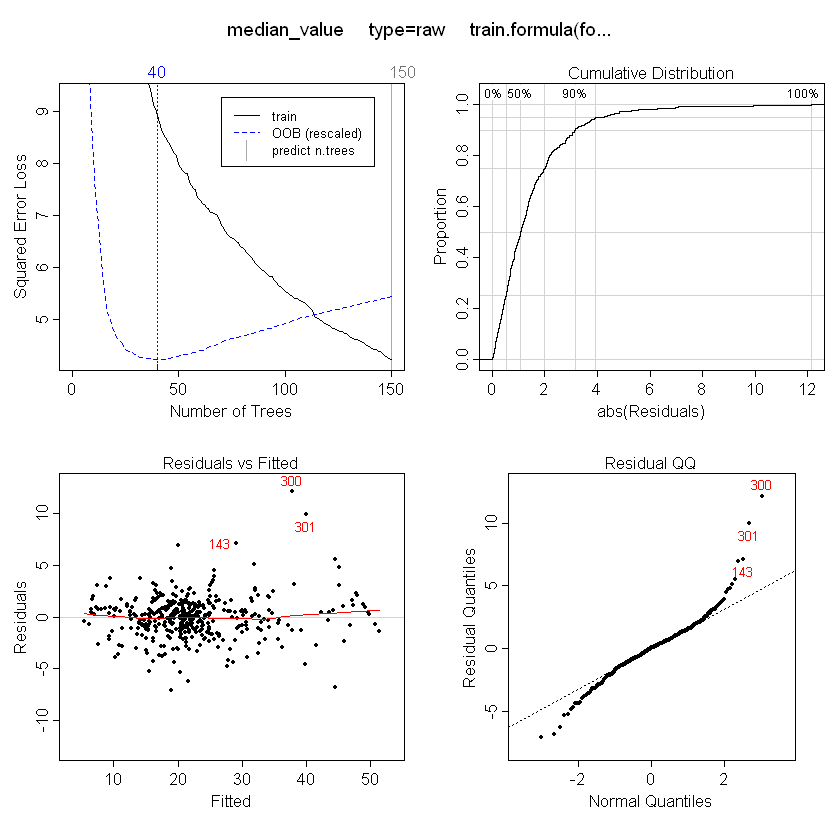

In [7]:
library(plotmo)
plotres(gbmFit)

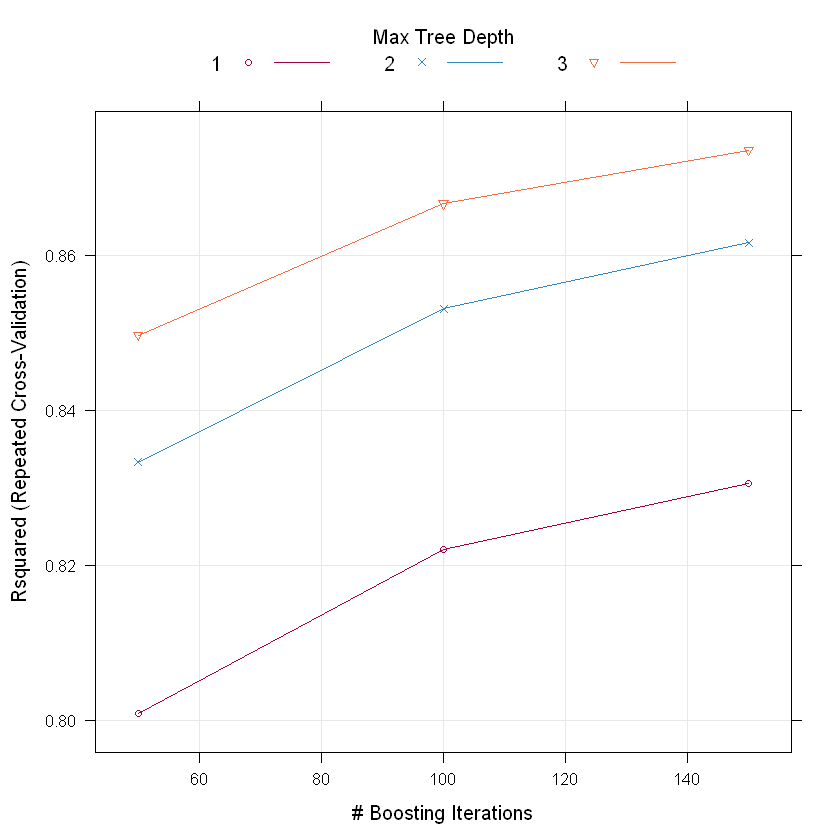

In [8]:
trellis.par.set(caretTheme())
plot(gbmFit, metric = 'Rsquared')

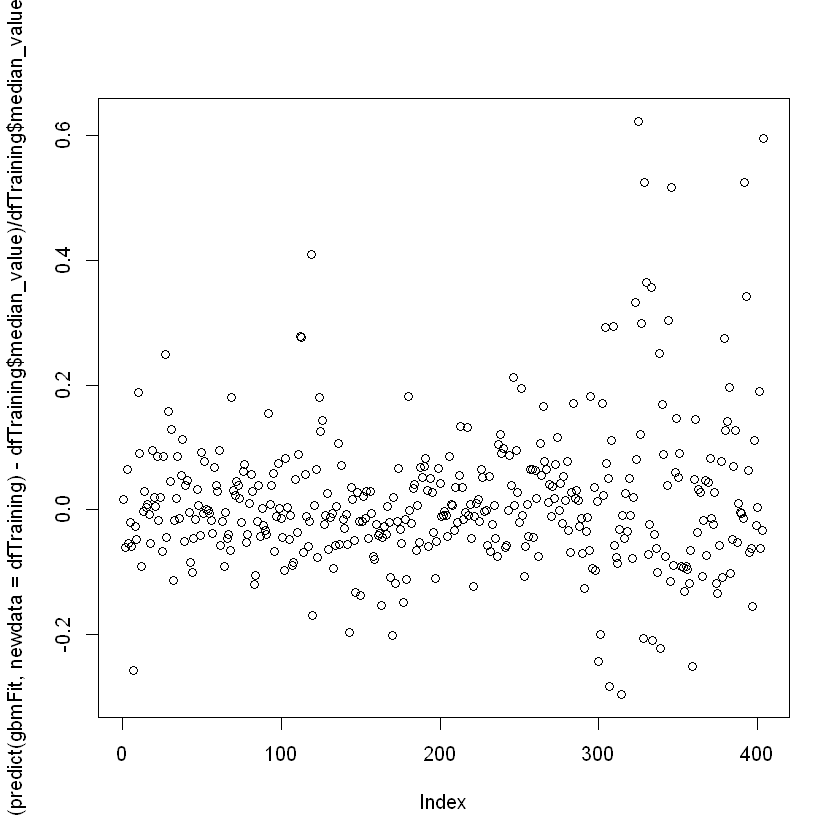

In [9]:
plot((predict(gbmFit, newdata = dfTraining) - dfTraining$median_value) / dfTraining$median_value)

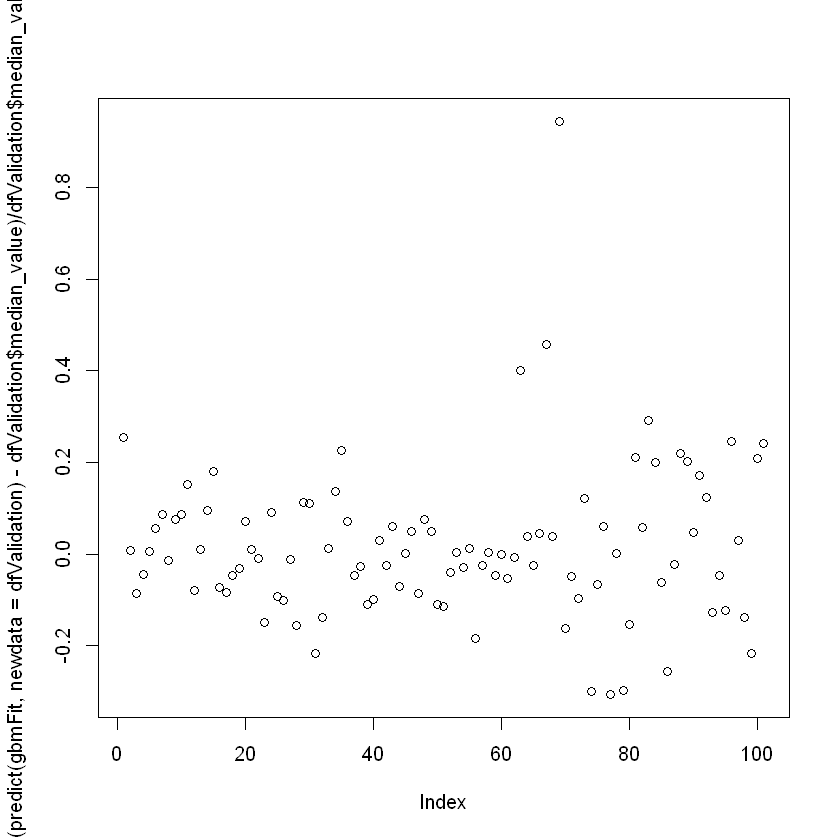

In [10]:
plot((predict(gbmFit, newdata = dfValidation) - dfValidation$median_value) / dfValidation$median_value)